# STDP learning for classifying touch input

Based on the architecture presented in Peter U. Diehl's seminal 2015 work: "Unsupervised learning of digit recognition using spike-timing-dependent plasticity", (https://www.frontiersin.org/articles/10.3389/fncom.2015.00099/full, https://github.com/peter-u-diehl/stdp-mnist)


In [1]:
# Increasing width of notebook, because of long lines
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [10]:
#brian2 installation!
!python -m pip install brian2
!python -m pip install brian2tools
#!conda install -c conda-forge brian2

     ---------------------------------------- 87.9/87.9 kB 4.9 MB/s eta 0:00:00
     ---------------------------------------- 67.0/67.0 kB ? eta 0:00:00
     ------------------------------------- 354.6/354.6 kB 21.5 MB/s eta 0:00:00
     ---------------------------------------- 43.8/43.8 kB ? eta 0:00:00


In [19]:
## Import statements
import numpy as np
import matplotlib.cm as cmap
import time
import os.path
import scipy 
import pickle
#import brian_no_units  #import it to deactivate unit checking --> This should NOT be done for testing/debugging 
import brian2 as b
from struct import unpack
from brian2 import *
from brian2tools import *

In [37]:
# for testing random things
19*26

494

In [4]:
### Loading data into relevant np arrays

# specify the location of the data
notebook_path = os.path.abspath("BRIAN_DIEHL_COOK_2015.ipynb")
#MNIST_data_path = os.path.join(os.path.dirname(notebook_path), "Datasets\\")
touch_data_vec_path = os.path.join(os.path.dirname(notebook_path), "Datasets\\Vector-data-of-A-Z\\")



def get_labeled_touch_vec_data(first_file_num, last_file_num, data_path):
    
    N = last_file_num - (first_file_num - 1)
    tot_N = N * 26
    x = np.zeros((tot_N, 5))
    y = np.zeros((tot_N, 1))
    
    pos = 0
    for file_num in range(first_file_num, last_file_num+1):
        file_name = 'Training' + str(file_num) + '.txt'
        file_path = data_path + file_name
        touch_vecs = open(file_path)
        for letter in range(26):
            y[letter + pos] = (ord(touch_vecs.read(1)) - 65)
            
            touch_vecs.read(1)
        x[pos:(pos+26), :] = np.transpose(np.loadtxt(file_path, skiprows=1))
        
        
        pos += 26
    data = {'x': x, 'y': y}
    return data

In [5]:
#------------------------------------------------------------------------------ 
# functions (from original for the most part)
#------------------------------------------------------------------------------     

def get_labeled_data(picklename, bTrain = True):
    """Read input-vector (image) and target class (label, 0-9) and return
       it as list of tuples.
    """
    if os.path.isfile('%s.pickle' % picklename):
        data = pickle.load(open('%s.pickle' % picklename))
    else:
        # Open the images with gzip in read binary mode
        if bTrain:
            images = open(MNIST_data_path + 'train-images.idx3-ubyte','rb')
            labels = open(MNIST_data_path + 'train-labels.idx1-ubyte','rb')
        else:
            images = open(MNIST_data_path + 't10k-images.idx3-ubyte','rb')
            labels = open(MNIST_data_path + 't10k-labels.idx1-ubyte','rb')
        # Get metadata for images
        images.read(4)  # skip the magic_number
        number_of_images = unpack('>I', images.read(4))[0]
        rows = unpack('>I', images.read(4))[0]
        cols = unpack('>I', images.read(4))[0]
        # Get metadata for labels
        labels.read(4)  # skip the magic_number
        N = unpack('>I', labels.read(4))[0]
    
        if number_of_images != N:
            raise Exception('number of labels did not match the number of images')
        # Get the data
        x = np.zeros((N, rows, cols), dtype=np.uint8)  # Initialize numpy array
        y = np.zeros((N, 1), dtype=np.uint8)  # Initialize numpy array
        for i in range(N):
            if i % 1000 == 0:
                print("i: %i" % i)
            x[i] = [[unpack('>B', images.read(1))[0] for unused_col in range(cols)]  for unused_row in range(rows) ]
            y[i] = unpack('>B', labels.read(1))[0]
            
        data = {'x': x, 'y': y, 'rows': rows, 'cols': cols}
        pickle.dump(data, open("%s.pickle" % picklename, "wb"))
    return data

def get_matrix_from_file(fileName):
    offset = len(ending) + 4
    if fileName[-4-offset] == 'X':
        n_src = n_input                
    else:
        if fileName[-3-offset]=='e':
            n_src = n_e
        else:
            n_src = n_i
    if fileName[-1-offset]=='e':
        n_tgt = n_e
    else:
        n_tgt = n_i
    readout = np.load(fileName)
    print(readout.shape, fileName)
    value_arr = np.zeros((n_src, n_tgt))
    if not readout.shape == (0,):
        value_arr[np.int32(readout[:,0]), np.int32(readout[:,1])] = readout[:,2]
    return value_arr


def save_connections(ending = ''):
    print('save connections')
    for connName in save_conns:
        connMatrix = connections[connName][:]
#         connListSparse = ([(i,j[0],j[1]) for i in range(connMatrix.shape[0]) for j in zip(connMatrix.rowj[i],connMatrix.rowdata[i])])
        connListSparse = ([(i,j,connMatrix[i,j]) for i in range(connMatrix.shape[0]) for j in range(connMatrix.shape[1]) ])
        np.save(data_path + 'weights/' + connName + ending, connListSparse)

def save_theta(ending = ''):
    print('save theta')
    for pop_name in population_names:
        np.save(data_path + 'weights/theta_' + pop_name + ending, neuron_groups[pop_name + 'e'].theta)

def normalize_weights():
    for connName in connections:
        if connName[1] == 'e' and connName[3] == 'e':
            connection = connections[connName][:]
            temp_conn = np.copy(connection)
            colSums = np.sum(temp_conn, axis = 0)
            colFactors = weight['ee_input']/colSums
            for j in range(n_e):#
                connection[:,j] *= colFactors[j]
            
def get_2d_input_weights():
    name = 'XeAe'
    weight_matrix = np.zeros((n_input, n_e))
    n_e_sqrt = int(np.sqrt(n_e))
    n_in_sqrt = int(np.sqrt(n_input))
    num_values_col = n_e_sqrt*n_in_sqrt
    num_values_row = num_values_col
    rearranged_weights = np.zeros((num_values_col, num_values_row))
    connMatrix = connections[name][:]
    weight_matrix = np.copy(connMatrix)
        
    for i in range(n_e_sqrt):
        for j in range(n_e_sqrt):
                rearranged_weights[i*n_in_sqrt : (i+1)*n_in_sqrt, j*n_in_sqrt : (j+1)*n_in_sqrt] = \
                    weight_matrix[:, i + j*n_e_sqrt].reshape((n_in_sqrt, n_in_sqrt))
    return rearranged_weights


def plot_2d_input_weights():
    name = 'XeAe'
    weights = get_2d_input_weights()
    fig = b.figure(fig_num, figsize = (18, 18))
    im2 = b.imshow(weights, interpolation = "nearest", vmin = 0, vmax = wmax_ee, cmap = cmap.get_cmap('hot_r'))
    b.colorbar(im2)
    b.title('weights of connection' + name)
    fig.canvas.draw()
    return im2, fig
    
def update_2d_input_weights(im, fig):
    weights = get_2d_input_weights()
    im.set_array(weights)
    fig.canvas.draw()
    return im

def get_current_performance(performance, current_example_num):
    current_evaluation = int(current_example_num/update_interval)
    start_num = current_example_num - update_interval
    end_num = current_example_num
    difference = outputNumbers[start_num:end_num, 0] - input_numbers[start_num:end_num]
    correct = len(np.where(difference == 0)[0])
    performance[current_evaluation] = correct / float(update_interval) * 100
    return performance

def plot_performance(fig_num):
    num_evaluations = int(num_examples/update_interval)
    time_steps = range(0, num_evaluations)
    performance = np.zeros(num_evaluations)
    fig = b.figure(fig_num, figsize = (5, 5))
    fig_num += 1
    ax = fig.add_subplot(111)
    im2, = ax.plot(time_steps, performance) #my_cmap
    b.ylim(ymax = 100)
    b.title('Classification performance')
    fig.canvas.draw()
    return im2, performance, fig_num, fig

def update_performance_plot(im, performance, current_example_num, fig):
    performance = get_current_performance(performance, current_example_num)
    im.set_ydata(performance)
    fig.canvas.draw()
    return im, performance
    
def get_recognized_number_ranking(assignments, spike_rates):
    summed_rates = [0] * 10
    num_assignments = [0] * 10
    for i in range(10):
        num_assignments[i] = len(np.where(assignments == i)[0])
        if num_assignments[i] > 0:
            summed_rates[i] = np.sum(spike_rates[assignments == i]) / num_assignments[i]
    return np.argsort(summed_rates)[::-1]

def get_new_assignments(result_monitor, input_numbers):
    assignments = np.zeros(n_e)
    input_nums = np.asarray(input_numbers)
    maximum_rate = [0] * n_e    
    for j in range(10):
        num_assignments = len(np.where(input_nums == j)[0])
        if num_assignments > 0:
            rate = np.sum(result_monitor[input_nums == j], axis = 0) / num_assignments
        for i in range(n_e):
            if rate[i] > maximum_rate[i]:
                maximum_rate[i] = rate[i]
                assignments[i] = j
    return assignments
    


In [6]:
#------------------------------------------------------------------------------ 
# load touch vec data
#------------------------------------------------------------------------------
start = time.time()
training = get_labeled_touch_vec_data(1,19,touch_data_vec_path)
end = time.time()
print('time needed to load training set:', end - start)
 
start = time.time()
testing = get_labeled_touch_vec_data(20,20,touch_data_vec_path)
end = time.time()
print('time needed to load test set:', end - start)


time needed to load training set: 0.11838030815124512
time needed to load test set: 0.005983591079711914


In [8]:
#------------------------------------------------------------------------------ 
# set parameters and equations
#------------------------------------------------------------------------------
test_mode = False

### Depracated method of setting preferences in brian1

# b.set_global_preferences( 
#                         defaultclock = b.Clock(dt=0.5*b.ms), # The default clock to use if none is provided or defined in any enclosing scope.
#                         useweave = True, # Defines whether or not functions should use inlined compiled C code where defined.
#                         gcc_options = ['-ffast-math -march=native'],  # Defines the compiler switches passed to the gcc compiler. 
#                         #For gcc versions 4.2+ we recommend using -march=native. By default, the -ffast-math optimizations are turned on 
#                         usecodegen = True,  # Whether or not to use experimental code generation support.
#                         usecodegenweave = True,  # Whether or not to use C with experimental code generation support.
#                         usecodegenstateupdate = True,  # Whether or not to use experimental code generation support on state updaters.
#                         usecodegenthreshold = False,  # Whether or not to use experimental code generation support on thresholds.
#                         usenewpropagate = True,  # Whether or not to use experimental new C propagation functions.
#                         usecstdp = True,  # Whether or not to use experimental new C STDP.
#                        ) 

### Setting preferences in brian2 (likely nothing needs to be set)



np.random.seed(0)
data_path = './'
if test_mode:
    weight_path = data_path + 'weights/'
    num_examples = 26
    use_testing_set = True
    do_plot_performance = False
    record_spikes = True
    ee_STDP_on = False
    update_interval = num_examples
else:
    weight_path = data_path + 'random/'  
    num_examples = (19 * 26) * 30 #Thirty repetitions with the data (arbitrary choice) 
    use_testing_set = False
    do_plot_performance = True
    #Huh? record spikes true nonetheless, what's the point
    if num_examples <= (19 * 26):    
        record_spikes = True
    else:
        record_spikes = True
    ee_STDP_on = True


ending = ''
n_input = 5
n_e = 400
n_i = n_e 
single_example_time = 0.35 * b.second #
resting_time = 0.15 * b.second
runtime = num_examples * (single_example_time + resting_time)
if num_examples <= 100:    
    update_interval = num_examples
    weight_update_interval = 20
else:
    update_interval = 100
    weight_update_interval = 1 ## I randomly just decreased all these numbers by two orders of magnitude
if num_examples <= 494:    
    save_connections_interval = 100
else:
    save_connections_interval = 100
    update_interval = 100

v_rest_e = -65. * b.mV 
v_rest_i = -60. * b.mV 
v_reset_e = -65. * b.mV
v_reset_i = -45. * b.mV
v_thresh_e = -52. * b.mV
v_thresh_i = -40. * b.mV
refrac_e = 5. * b.ms
refrac_i = 2. * b.ms

conn_structure = 'dense'
weight = {}
delay = {}
input_population_names = ['X']
population_names = ['A']
input_connection_names = ['XA']
save_conns = ['XeAe']
input_conn_names = ['ee_input'] 
recurrent_conn_names = ['ei', 'ie']
weight['ee_input'] = 78.
delay['ee_input'] = (0*b.ms,10*b.ms)
delay['ei_input'] = (0*b.ms,5*b.ms)
input_intensity = 64.
start_input_intensity = input_intensity

tc_pre_ee = 20*b.ms
tc_post_1_ee = 20*b.ms
tc_post_2_ee = 40*b.ms
nu_ee_pre =  0.0001      # learning rate
nu_ee_post = 0.01       # learning rate
wmax_ee = 1.0
exp_ee_pre = 0.2
exp_ee_post = exp_ee_pre
STDP_offset = 0.4

if test_mode:
    scr_e = 'v = v_reset_e; timer = 0*ms'
else:
    tc_theta = 1e7 * b.ms
    theta_plus_e = 0.05 * b.mV
    scr_e = 'v = v_reset_e; theta += theta_plus_e; timer = 0*ms'
offset = 20.0*b.mV
v_thresh_e = '(v>(theta - offset + ' + str(v_thresh_e) + ')) * (timer>refrac_e)'


neuron_eqs_e = '''
        dv/dt = ((v_rest_e - v) + (I_synE+I_synI) / nS) / (100*ms)  : volt
        I_synE = ge * nS *         -v                           : amp
        I_synI = gi * nS * (-100.*mV-v)                          : amp
        dge/dt = -ge/(1.0*ms)                                   : 1
        dgi/dt = -gi/(2.0*ms)                                  : 1
        '''
if test_mode:
    neuron_eqs_e += '\n  theta      :volt'
else:
    neuron_eqs_e += '\n  dtheta/dt = -theta / (tc_theta)  : volt'
neuron_eqs_e += '\n  dtimer/dt = 0.1  : second'

neuron_eqs_i = '''
        dv/dt = ((v_rest_i - v) + (I_synE+I_synI) / nS) / (10*ms)  : volt
        I_synE = ge * nS *         -v                           : amp
        I_synI = gi * nS * (-85.*mV-v)                          : amp
        dge/dt = -ge/(1.0*ms)                                   : 1
        dgi/dt = -gi/(2.0*ms)                                  : 1
        '''
eqs_stdp_ee = '''
                post2before                            : 1.0
                dpre/dt   =   -pre/(tc_pre_ee)         : 1.0
                dpost1/dt  = -post1/(tc_post_1_ee)     : 1.0
                dpost2/dt  = -post2/(tc_post_2_ee)     : 1.0
            '''
eqs_stdp_pre_ee = 'pre = 1.; w -= nu_ee_pre * post1'
eqs_stdp_post_ee = 'post2before = post2; w += nu_ee_post * pre * post2before; post1 = 1.; post2 = 1.'
    
b.ion()
fig_num = 1
neuron_groups = {}
input_groups = {}
connections = {}
stdp_methods = {}
rate_monitors = {}
spike_monitors = {}
spike_counters = {}
result_monitor = np.zeros((update_interval,n_e))


# I simply removed "compile = True" and "freeze=True" from the parameter lists below 
neuron_groups['e'] = b.NeuronGroup(n_e*len(population_names), neuron_eqs_e, threshold= v_thresh_e, refractory= refrac_e, reset= scr_e)

neuron_groups['i'] = b.NeuronGroup(n_i*len(population_names), neuron_eqs_i, threshold= v_thresh_i, refractory= refrac_i, reset= v_reset_i)


create neuron group A
create recurrent connections
(400, 3) ./random/../random/AeAi.npy
(160000, 3) ./random/../random/AiAe.npy
create monitors for A
create connections between X and A


ValueError: could not broadcast input array from shape (2,) into shape (2000,)

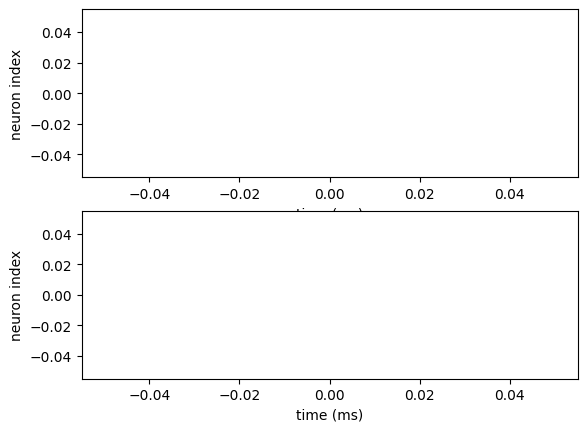

In [30]:
#------------------------------------------------------------------------------ 
# create network population and recurrent connections
#------------------------------------------------------------------------------ 
for name in population_names:
    print('create neuron group', name)
    
    neuron_groups[name+'e'] = neuron_groups['e'][:n_e]
    neuron_groups[name+'i'] = neuron_groups['i'][:n_i]
    
    neuron_groups[name+'e'].v = v_rest_e - 40. * b.mV
    neuron_groups[name+'i'].v = v_rest_i - 40. * b.mV
    if test_mode or weight_path[-8:] == 'weights/':
        neuron_groups['e'].theta = np.load(weight_path + 'theta_' + name + ending + '.npy')
    else:
        neuron_groups['e'].theta = np.ones((n_e)) * 20.0*b.mV
    
    print('create recurrent connections')
    for conn_type in recurrent_conn_names:
        connName = name+conn_type[0]+name+conn_type[1]
        weightMatrix = get_matrix_from_file(weight_path + '../random/' + connName + ending + '.npy')
        connections[connName] = b.Synapses(neuron_groups[connName[0:2]], neuron_groups[connName[2:4]], 'w : 1', on_pre= 'g'+conn_type[0]+'+=w')
        connections[connName].connect()
        connections[connName].w = weightMatrix.flatten()
                
    if ee_STDP_on:
        if 'ee' in recurrent_conn_names:
            stdp_methods[name+'e'+name+'e'] = b.STDP(connections[name+'e'+name+'e'], eqs=eqs_stdp_ee, pre = eqs_stdp_pre_ee, 
                                                           post = eqs_stdp_post_ee, wmin=0., wmax= wmax_ee)

    print('create monitors for', name)
    rate_monitors[name+'e'] = b.PopulationRateMonitor(neuron_groups[name+'e']) #Used to have the following depracated parameter: bin = (single_example_time+resting_time)/b.second
    rate_monitors[name+'i'] = b.PopulationRateMonitor(neuron_groups[name+'i'])
    spike_counters[name+'e'] = b.SpikeMonitor(neuron_groups[name+'e'])
    
    if record_spikes:
        spike_monitors[name+'e'] = b.SpikeMonitor(neuron_groups[name+'e'])
        spike_monitors[name+'i'] = b.SpikeMonitor(neuron_groups[name+'i'])

if record_spikes:
    b.figure(fig_num)
    fig_num += 1
    b.ion()
    b.subplot(211)
    brian_plot(spike_monitors['Ae']) # Depracated parameters for b.raster_plot which used to lie here: refresh=1000*b.ms, showlast=1000*b.ms
    b.subplot(212)
    brian_plot(spike_monitors['Ai'])


#------------------------------------------------------------------------------ 
# create input population and connections from input populations 
#------------------------------------------------------------------------------ 
pop_values = [0,0,0]
for i,name in enumerate(input_population_names):
    input_groups[name+'e'] = b.PoissonGroup(n_input, 0*Hz)
    rate_monitors[name+'e'] = b.PopulationRateMonitor(input_groups[name+'e']) #  bin = (single_example_time+resting_time)/b.second

for name in input_connection_names:
    print('create connections between', name[0], 'and', name[1])
    for connType in input_conn_names:
        connName = name[0] + connType[0] + name[1] + connType[1]
        ### The weightMatrix is just totally random for me rn. Therefore, I will replace the below weightMatrix with just np.rand
        # weightMatrix = get_matrix_from_file(weight_path + connName + ending + '.npy')
        weightMatrix = np.random.rand(n_input, n_e)
        connections[connName] = b.Synapses(input_groups[connName[0:2]], neuron_groups[connName[2:4]], 'w : 1', on_pre= 'g'+conn_type[0]+'+=w')
        # this is depracated from brian1, I'm not sure what it does so I'm leaving it here for later reference max_delay=delay[connType][1])
        connections[connName].connect()
        connections[connName].w = weightMatrix.flatten()
        connections[connName].delay = delay[connType]
    if ee_STDP_on:
        print('create STDP for connection', name[0]+'e'+name[1]+'e')
        stdp_methods[name[0]+'e'+name[1]+'e'] = b.STDP(connections[name[0]+'e'+name[1]+'e'], eqs=eqs_stdp_ee, pre = eqs_stdp_pre_ee, 
                                                       post = eqs_stdp_post_ee, wmin=0., wmax= wmax_ee)


#------------------------------------------------------------------------------ 
# run the simulation and set inputs
#------------------------------------------------------------------------------ 
previous_spike_count = np.zeros(n_e)
assignments = np.zeros(n_e)
input_numbers = [0] * num_examples
outputNumbers = np.zeros((num_examples, 10))
if not test_mode:
    input_weight_monitor, fig_weights = plot_2d_input_weights()
    fig_num += 1
if do_plot_performance:
    performance_monitor, performance, fig_num, fig_performance = plot_performance(fig_num)
for i,name in enumerate(input_population_names):
    input_groups[name+'e'].rate = 0
b.run(0)
j = 0
while j < (int(num_examples)):
    if test_mode:
        if use_testing_set:
            rates = testing['x'][j%100,:,:].reshape((n_input)) *  input_intensity
        else:
            rates = training['x'][j%494,:,:].reshape((n_input)) *  input_intensity
    else:
        normalize_weights()
        rates = training['x'][j%494,:,:].reshape((n_input)) *  input_intensity
    input_groups['Xe'].rate = rates
#     print('run number:', j+1, 'of', int(num_examples))
    b.run(single_example_time, report='text')
            
    if j % update_interval == 0 and j > 0:
        assignments = get_new_assignments(result_monitor[:], input_numbers[j-update_interval : j])
    if j % weight_update_interval == 0 and not test_mode:
        update_2d_input_weights(input_weight_monitor, fig_weights)
    if j % save_connections_interval == 0 and j > 0 and not test_mode:
        save_connections(str(j))
        save_theta(str(j))
    
    current_spike_count = np.asarray(spike_counters['Ae'].count[:]) - previous_spike_count
    previous_spike_count = np.copy(spike_counters['Ae'].count[:])
    if np.sum(current_spike_count) < 5:
        input_intensity += 1
        for i,name in enumerate(input_population_names):
            input_groups[name+'e'].rate = 0
        b.run(resting_time)
    else:
        result_monitor[j%update_interval,:] = current_spike_count
        if test_mode and use_testing_set:
            input_numbers[j] = testing['y'][j%100][0]
        else:
            input_numbers[j] = training['y'][j%494][0]
        outputNumbers[j,:] = get_recognized_number_ranking(assignments, result_monitor[j%update_interval,:])
        if j % 100 == 0 and j > 0:
            print('runs done:', j, 'of', int(num_examples))
        if j % update_interval == 0 and j > 0:
            if do_plot_performance:
                unused, performance = update_performance_plot(performance_monitor, performance, j, fig_performance)
                print('Classification performance', performance[:(j/float(update_interval))+1])
        for i,name in enumerate(input_population_names):
            input_groups[name+'e'].rate = 0
        b.run(resting_time)
        input_intensity = start_input_intensity
        j += 1


#------------------------------------------------------------------------------ 
# save results
#------------------------------------------------------------------------------ 
print('save results')
if not test_mode:
    save_theta()
if not test_mode:
    save_connections()
else:
    np.save(data_path + 'activity/resultPopVecs' + str(num_examples), result_monitor)
    np.save(data_path + 'activity/inputNumbers' + str(num_examples), input_numbers)
    

#------------------------------------------------------------------------------ 
# plot results
#------------------------------------------------------------------------------ 
if rate_monitors:
    b.figure(fig_num)
    fig_num += 1
    for i, name in enumerate(rate_monitors):
        b.subplot(len(rate_monitors), 1, i)
        b.plot(rate_monitors[name].times/b.second, rate_monitors[name].rate, '.')
        b.title('Rates of population ' + name)
    
if spike_monitors:
    b.figure(fig_num)
    fig_num += 1
    for i, name in enumerate(spike_monitors):
        b.subplot(len(spike_monitors), 1, i)
        b.raster_plot(spike_monitors[name])
        b.title('Spikes of population ' + name)
        
if spike_counters:
    b.figure(fig_num)
    fig_num += 1
    for i, name in enumerate(spike_counters):
        b.subplot(len(spike_counters), 1, i)
        b.plot(spike_counters['Ae'].count[:])
        b.title('Spike count of population ' + name)

plot_2d_input_weights()
b.ioff()
b.show()





In [ ]:
##### EVALUATOR file, note to self, figure all this after figuring the first part


import brian as b
from brian import *
import numpy as np
import matplotlib
import matplotlib.cm as cmap
import time
import os.path
import scipy 
import cPickle as pickle
from struct import unpack
import brian.experimental.realtime_monitor as rltmMon


#------------------------------------------------------------------------------ 
# functions
#------------------------------------------------------------------------------     
def get_labeled_data(picklename, bTrain = True):
    """Read input-vector (image) and target class (label, 0-9) and return
       it as list of tuples.
    """
    if os.path.isfile('%s.pickle' % picklename):
        data = pickle.load(open('%s.pickle' % picklename))
    else:
        # Open the images with gzip in read binary mode
        if bTrain:
            images = open(MNIST_data_path + 'train-images.idx3-ubyte','rb')
            labels = open(MNIST_data_path + 'train-labels.idx1-ubyte','rb')
        else:
            images = open(MNIST_data_path + 't10k-images.idx3-ubyte','rb')
            labels = open(MNIST_data_path + 't10k-labels.idx1-ubyte','rb')
        # Get metadata for images
        images.read(4)  # skip the magic_number
        number_of_images = unpack('>I', images.read(4))[0]
        rows = unpack('>I', images.read(4))[0]
        cols = unpack('>I', images.read(4))[0]
        # Get metadata for labels
        labels.read(4)  # skip the magic_number
        N = unpack('>I', labels.read(4))[0]
        if number_of_images != N:
            raise Exception('number of labels did not match the number of images')
        # Get the data
        x = np.zeros((N, rows, cols), dtype=np.uint8)  # Initialize numpy array
        y = np.zeros((N, 1), dtype=np.uint8)  # Initialize numpy array
        for i in xrange(N):
            if i % 1000 == 0:
                print("i: %i" % i)
            x[i] = [[unpack('>B', images.read(1))[0] for unused_col in xrange(cols)]  for unused_row in xrange(rows) ]
            y[i] = unpack('>B', labels.read(1))[0]
        data = {'x': x, 'y': y, 'rows': rows, 'cols': cols}
        pickle.dump(data, open("%s.pickle" % picklename, "wb"))
    return data

def get_recognized_number_ranking(assignments, spike_rates):
    summed_rates = [0] * 10
    num_assignments = [0] * 10
    for i in xrange(10):
        num_assignments[i] = len(np.where(assignments == i)[0])
        if num_assignments[i] > 0:
            summed_rates[i] = np.sum(spike_rates[assignments == i]) / num_assignments[i]
    return np.argsort(summed_rates)[::-1]

def get_new_assignments(result_monitor, input_numbers):
    print result_monitor.shape
    assignments = np.ones(n_e) * -1 # initialize them as not assigned
    input_nums = np.asarray(input_numbers)
    maximum_rate = [0] * n_e    
    for j in xrange(10):
        num_inputs = len(np.where(input_nums == j)[0])
        if num_inputs > 0:
            rate = np.sum(result_monitor[input_nums == j], axis = 0) / num_inputs
        for i in xrange(n_e):
            if rate[i] > maximum_rate[i]:
                maximum_rate[i] = rate[i]
                assignments[i] = j 
    return assignments

MNIST_data_path = './'
data_path = './activity/'
training_ending = '100'
testing_ending = '100'
start_time_training = 0
end_time_training = int(training_ending)
start_time_testing = 0
end_time_testing = int(testing_ending)

n_e = 400
n_input = 784
ending = ''

print 'load MNIST'
training = get_labeled_data(MNIST_data_path + 'training')
testing = get_labeled_data(MNIST_data_path + 'testing', bTrain = False)

print 'load results'
training_result_monitor = np.load(data_path + 'resultPopVecs' + training_ending + ending + '.npy')
training_input_numbers = np.load(data_path + 'inputNumbers' + training_ending + '.npy')
testing_result_monitor = np.load(data_path + 'resultPopVecs' + testing_ending + '.npy')
testing_input_numbers = np.load(data_path + 'inputNumbers' + testing_ending + '.npy')
print training_result_monitor.shape

print 'get assignments'
test_results = np.zeros((10, end_time_testing-start_time_testing))
test_results_max = np.zeros((10, end_time_testing-start_time_testing))
test_results_top = np.zeros((10, end_time_testing-start_time_testing))
test_results_fixed = np.zeros((10, end_time_testing-start_time_testing))
assignments = get_new_assignments(training_result_monitor[start_time_training:end_time_training], 
                                  training_input_numbers[start_time_training:end_time_training])
print assignments
counter = 0 
num_tests = end_time_testing / 100
sum_accurracy = [0] * num_tests
while (counter < num_tests):
    end_time = min(end_time_testing, 100*(counter+1))
    start_time = 100*counter
    test_results = np.zeros((10, end_time-start_time))
    print 'calculate accuracy for sum'
    for i in xrange(end_time - start_time):
        test_results[:,i] = get_recognized_number_ranking(assignments, 
                                                          testing_result_monitor[i+start_time,:])
    difference = test_results[0,:] - testing_input_numbers[start_time:end_time]
    correct = len(np.where(difference == 0)[0])
    incorrect = np.where(difference != 0)[0]
    sum_accurracy[counter] = correct/float(end_time-start_time) * 100
    print 'Sum response - accuracy: ', sum_accurracy[counter], ' num incorrect: ', len(incorrect)
    counter += 1
print 'Sum response - accuracy --> mean: ', np.mean(sum_accurracy),  '--> standard deviation: ', np.std(sum_accurracy)


b.show()

In [ ]:
### Random connection generating file
'''
Created on 15.12.2014

@author: Peter U. Diehl
'''

import scipy.ndimage as sp
import numpy as np
import pylab


def randomDelay(minDelay, maxDelay):
    return np.random.rand()*(maxDelay-minDelay) + minDelay
        
        
def computePopVector(popArray):
    size = len(popArray)
    complex_unit_roots = np.array([np.exp(1j*(2*np.pi/size)*cur_pos) for cur_pos in xrange(size)])
    cur_pos = (np.angle(np.sum(popArray * complex_unit_roots)) % (2*np.pi)) / (2*np.pi)
    return cur_pos

        
def sparsenMatrix(baseMatrix, pConn):
    weightMatrix = np.zeros(baseMatrix.shape)
    numWeights = 0
    numTargetWeights = baseMatrix.shape[0] * baseMatrix.shape[1] * pConn
    weightList = [0]*int(numTargetWeights)
    while numWeights < numTargetWeights:
        idx = (np.int32(np.random.rand()*baseMatrix.shape[0]), np.int32(np.random.rand()*baseMatrix.shape[1]))
        if not (weightMatrix[idx]):
            weightMatrix[idx] = baseMatrix[idx]
            weightList[numWeights] = (idx[0], idx[1], baseMatrix[idx])
            numWeights += 1
    return weightMatrix, weightList
        
    
def create_weights():
    
    nInput = 784
    nE = 400
    nI = nE 
    dataPath = './random/'
    weight = {}
    weight['ee_input'] = 0.3 
    weight['ei_input'] = 0.2 
    weight['ee'] = 0.1
    weight['ei'] = 10.4
    weight['ie'] = 17.0
    weight['ii'] = 0.4
    pConn = {}
    pConn['ee_input'] = 1.0 
    pConn['ei_input'] = 0.1 
    pConn['ee'] = 1.0
    pConn['ei'] = 0.0025
    pConn['ie'] = 0.9
    pConn['ii'] = 0.1
    
    
    print 'create random connection matrices'
    connNameList = ['XeAe']
    for name in connNameList:
        weightMatrix = np.random.random((nInput, nE)) + 0.01
        weightMatrix *= weight['ee_input']
        if pConn['ee_input'] < 1.0:
            weightMatrix, weightList = sparsenMatrix(weightMatrix, pConn['ee_input'])
        else:
            weightList = [(i, j, weightMatrix[i,j]) for j in xrange(nE) for i in xrange(nInput)]
        np.save(dataPath+name, weightList)
    
    
    
    print 'create connection matrices from E->I which are purely random'
    connNameList = ['XeAi']
    for name in connNameList:
        weightMatrix = np.random.random((nInput, nI))
        weightMatrix *= weight['ei_input']
        weightMatrix, weightList = sparsenMatrix(weightMatrix, pConn['ei_input'])
        print 'save connection matrix', name
        np.save(dataPath+name, weightList)
        
    
    
    print 'create connection matrices from E->I which are purely random'
    connNameList = ['AeAi']
    for name in connNameList:
        if nE == nI:
            weightList = [(i, i, weight['ei']) for i in xrange(nE)]
        else:
            weightMatrix = np.random.random((nE, nI))
            weightMatrix *= weight['ei']
            weightMatrix, weightList = sparsenMatrix(weightMatrix, pConn['ei'])
        print 'save connection matrix', name
        np.save(dataPath+name, weightList)
        
        
        
    print 'create connection matrices from I->E which are purely random'
    connNameList = ['AiAe']
    for name in connNameList:
        if nE == nI:
            weightMatrix = np.ones((nI, nE))
            weightMatrix *= weight['ie']
            for i in xrange(nI):
                weightMatrix[i,i] = 0
            weightList = [(i, j, weightMatrix[i,j]) for i in xrange(nI) for j in xrange(nE)]
        else:
            weightMatrix = np.random.random((nI, nE))
            weightMatrix *= weight['ie']
            weightMatrix, weightList = sparsenMatrix(weightMatrix, pConn['ie'])
        print 'save connection matrix', name
        np.save(dataPath+name, weightList)
    
         
if __name__ == "__main__":
    create_weights()